<a href="https://colab.research.google.com/github/Engineer-Gustavo-Softworks/TRATAMENTO-DE-DADOS-INMET-TAREFA-7-E-8/blob/main/METODOS_PARA_CURVA_DE_WEIBULL_GOIANIA_2009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Planilha Goiania 2009_excel.xlsx to Planilha Goiania 2009_excel.xlsx


In [2]:
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, weibull_min
from scipy.special import gamma

df = pd.read_excel('Planilha Goiania 2009_excel.xlsx', engine='openpyxl')

df_copia = df.copy (deep = True)
df_copia [['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'VENTO, VELOCIDADE HORARIA (m/s)']] = df_copia [['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'VENTO, VELOCIDADE HORARIA (m/s)']].replace(-9999,np.nan)

#De acordo com a distribuição do feature, decidi substituir os valores nulos por um método.
df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].fillna(df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].mean(), inplace = True) #média

# Verificando a exitencia de valores duplicados:
df_copia.duplicated().sum()



<ipython-input-2-4d4602fca984>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].fillna(df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].mean(), inplace = True) #média


np.int64(0)

,DATA (YYYY-MM-DD),"VENTO, VELOCIDADE HORARIA (m/s)"
count,8760,8760.000000
mean,2009-07-01 23:59:59.999999744,1.168302
min,2009-01-01 00:00:00,0.000000
25%,2009-04-02 00:00:00,0.200000
50%,2009-07-02 00:00:00,1.100000
75%,2009-10-01 00:00:00,1.800000
max,2009-12-31 00:00:00,6.700000
std,NaN,1.053762


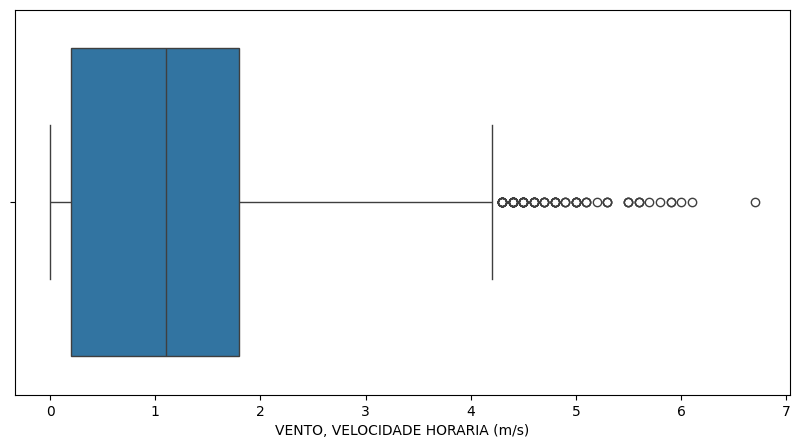

In [3]:
# Analisando a existencia de outleirs em 'VENTO, VELOCIDADE HORARIA (m/s)'
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_copia['VENTO, VELOCIDADE HORARIA (m/s)'])

df_copia.describe()



In [4]:
df_copia.isnull().sum()

,0
DATA (YYYY-MM-DD),0
HORA (UTC),0
"VENTO, VELOCIDADE HORARIA (m/s)",0


In [5]:
df_copia.head()

,DATA (YYYY-MM-DD),HORA (UTC),"VENTO, VELOCIDADE HORARIA (m/s)"
0,2009-01-01,00:00:00,1.5
1,2009-01-01,01:00:00,0.5
2,2009-01-01,02:00:00,0.1
3,2009-01-01,03:00:00,0.0
4,2009-01-01,04:00:00,0.0


> MÉTODOS PARA CURVA DE WEIBULL

Parâmetro beta (forma): 1.3519
Parâmetro eta (escala): 1.5845
[Momentos] beta: 1.3366, eta: 1.5570
[Máxima Verossimilhança] beta: 1.4246, eta: 1.5700


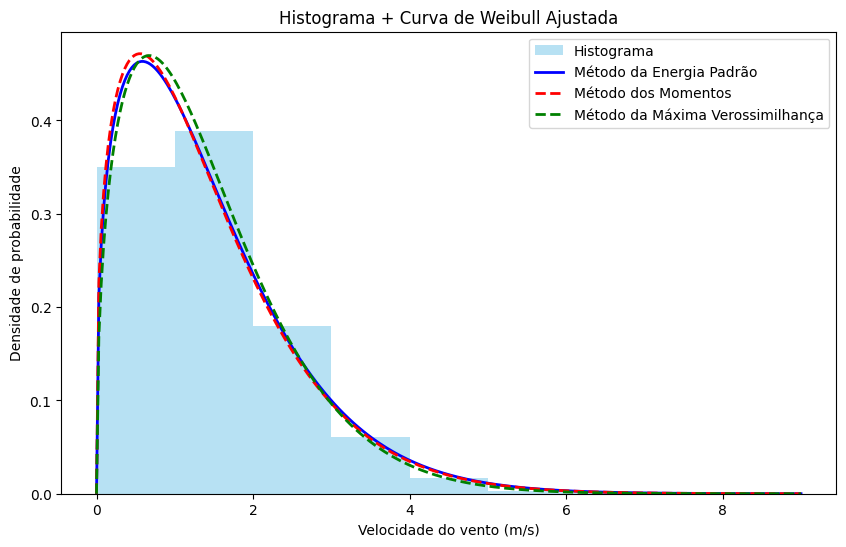

Limites dos bins do histograma: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Intervalo x para curva Weibull: 0.0 a 9.0


In [6]:
#Carregar os dados

coluna = 'VENTO, VELOCIDADE HORARIA (m/s)'
dados = df_copia[coluna].dropna().sort_values().values
dados = dados[dados > 0]
n = len(dados)

# -------Método da Enegia Padrão-------#

#Estimar a função de distribuição acumulada
i = np.arange(1, n + 1)
F = (i - 0.3) / (n + 0.4)

#Linearização e regressão
ln_t = np.log(dados)
ln_ln = np.log(-np.log(1 - F))

slope, intercept, *_ = linregress(ln_t, ln_ln)
beta = slope
eta = np.exp(-intercept / beta)

print(f"Parâmetro beta (forma): {beta:.4f}")
print(f"Parâmetro eta (escala): {eta:.4f}")

# -------Método dos Momentos-------#

# Momentos amostrais
media = np.mean(dados)
variancia = np.var(dados)

# Estimativa de beta (forma) por aproximação
def estimar_beta_mm(media, variancia):
    # Adjusted search range and number of points for potentially better convergence
    for b in np.linspace(0.1, 20, 50000):
        # Ensure that the arguments to gamma are positive
        if 1 + 2/b <= 0 or 1 + 1/b <= 0:
            continue
        r = gamma(1 + 2/b) - (gamma(1 + 1/b))**2
        # Increased tolerance
        if np.isclose(r, variancia / media**2, atol=1e-3):
            return b
    return None

beta_mm = estimar_beta_mm(media, variancia)

# Add a check for beta_mm being None
if beta_mm is not None:
    eta_mm = media / gamma(1 + 1/beta_mm)
    print(f"[Momentos] beta: {beta_mm:.4f}, eta: {eta_mm:.4f}")
else:
    eta_mm = None # Set eta_mm to None as well if beta_mm is None
    print("[Momentos] Não foi possível estimar beta e eta pelo Método dos Momentos.")



# -------Método da Máxima Verossimilhança-------#

# Ajuste da distribuição Weibull aos dados
params = weibull_min.fit(dados, floc=0)
beta_mle, loc_mle, eta_mle = params
print(f"[Máxima Verossimilhança] beta: {beta_mle:.4f}, eta: {eta_mle:.4f}")

# Histograma + Curva de Weibull ajustada
plt.figure(figsize=(10, 6))

# Histograma normalizado
counts, bins, _ = plt.hist(dados, bins=[0,1,2,3,4,5,6,7,8,9], density=True, alpha=0.6, color='skyblue', label='Histograma')

#------------Curva de Weibull / MEP---------------#
# Eixo x para curva Weibull: mesma faixa do histograma
x = np.linspace(min(bins), max(bins), 300)

# Função densidade Weibull ajustada
weibull_pdf = (beta / eta) * (x / eta)**(beta - 1) * np.exp(-(x / eta)**beta)

# Plot da curva
plt.plot(x, weibull_pdf, 'b', lw=2, label='Método da Energia Padrão')

#------------Curva de Weibull / MM---------------#
pdf_mm = (beta_mm / eta_mm) * (x / eta_mm)**(beta_mm - 1) * np.exp(-(x / eta_mm)**beta_mm)
plt.plot(x, pdf_mm, 'r--', lw=2, label='Método dos Momentos')

#------------Curva de Weibull / MMV---------------#
pdf_mle = (beta_mle / eta_mle) * (x / eta_mle)**(beta_mle - 1) * np.exp(-(x / eta_mle)**beta_mle)
plt.plot(x, pdf_mle, 'g--', lw=2, label='Método da Máxima Verossimilhança')

# Ajustes visuais
plt.title('Histograma + Curva de Weibull Ajustada')
plt.xlabel('Velocidade do vento (m/s)')
plt.ylabel('Densidade de probabilidade')
plt.legend()
plt.grid(False)
plt.show()

print("Limites dos bins do histograma:", bins)
print("Intervalo x para curva Weibull:", x[0], "a", x[-1])

In [ ]:
print(dados)
len(dados)
print(np.any(dados <= 0))
print(f"Beta: {beta}")
print(f"Eta: {eta}")

[0.  0.  0.  ... 6.9 7.  7.3]
True
Beta: nan
Eta: nan
